In [85]:
import sys
sys.path.append("..")

import json

from pathlib import Path
from collections import defaultdict
from src.graph.load_gfa import load_gfa
from src.utils.params_from_path import params_from_path

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set_theme(rc = {'figure.figsize':(10,8)})
# sns.set(rc = {'figure.figsize':(6,4)})

NSEQS = 20
NAME = f"{NSEQS}-sars-cov-2-ena"
PATH_SAVE = Path(f"../output-experiments-paper/sars-cov-2-{NSEQS}-row_maximal-vs-complete-blocks")
PATH_SAVE.mkdir(exist_ok=True, parents=True)

## Fontsizes plots
FONTSIZE_TITLE = 18
FONTSIZE_SUBTITLE = 16
FONTSIZE_X = 16
FONTSIZE_Y = 16
FONTSIZE_TOOLS = 14 

FONTSIZE_GRID_TITLE = 18
FONTSIZE_GRID_SUBTITLE = 16
FONTSIZE_GRID_X = 16
FONTSIZE_GRID_Y = 16
FONTSIZE_GRID_TOOLS = 14 

LEGEND = True


In [86]:
def load_info_graph(path_gfa):
    info = dict()

    nodes, edges, paths, node_depth = load_gfa(path_gfa)

    info["n_nodes"] = len(nodes)
    info["n_edges"] = len(edges)

    # 2. length of the graph
    info["len_graph"] = sum([v["len"] for k,v in nodes.items()])

    # 3. number of potential seeds
    info["potential_seeds_len10"] = sum([v["len"] - 10 + 1 for k,v in nodes.items() if v["len"]>= 10])
    info["potential_seeds_len15"] = sum([v["len"] - 15 + 1 for k,v in nodes.items() if v["len"]>= 15])
    info["potential_seeds_len20"] = sum([v["len"] - 20 + 1 for k,v in nodes.items() if v["len"]>= 20])

    # 4. node depth
    info["nodes_depth_gt_03"] = len([k for k,v in node_depth.items() if v >= 0.3]) / len(nodes)

    return info

In [87]:
def get_info_from_exp(path_exp):
    info = []
    # config info from the experiment
    with open(Path(path_exp).joinpath("config.json"), "r") as fp:
        config = json.load(fp)
    decomposition = "complete" if config["DECOMPOSITION"]["STANDARD"] is True else "row-maximal"
    alpha_consistent = True if config["DECOMPOSITION"]["ALPHA_CONSISTENT"] is True else False

    # load info of graphs for each experiment
    path_graphs = Path(path_exp).joinpath("gfa-unchop").rglob(f"*{NAME}.gfa")
    for path in path_graphs:
        params = params_from_path(path, output_dict=True)
        params["alpha_consistent"] = alpha_consistent
        params["decomposition"] = decomposition
        params["path"] = path

        info_pb = load_info_graph(path)        
        params.update(info_pb)

        info.append(params)

    return pd.DataFrame(info)

### pggb


In [88]:
# sarscov2 
path_pggb = list(Path(f"../paper-graphs-tools/pggb/{NSEQS}-sars-cov-2-ena").rglob("*.gfa"))[0]
info_pggb = load_info_graph(path_pggb)
info_pggb

{'n_nodes': 807,
 'n_edges': 1066,
 'len_graph': 30358,
 'potential_seeds_len10': 27461,
 'potential_seeds_len15': 26322,
 'potential_seeds_len20': 25266,
 'nodes_depth_gt_03': 0.654275092936803}

### vg

In [89]:
# vg
path_vg = Path(f"../paper-graphs-tools/vg/{NSEQS}-sars-cov-2-ena.gfa")
info_vg =  load_info_graph(path_vg) 
info_vg

{'n_nodes': 790,
 'n_edges': 1049,
 'len_graph': 30140,
 'potential_seeds_len10': 27299,
 'potential_seeds_len15': 26179,
 'potential_seeds_len20': 25138,
 'nodes_depth_gt_03': 0.6746835443037975}

### pangeblocks

In [90]:
path_complete_experiment = f"/data/analysis-paper/paper-experiment-decomposition/sars-cov-2-{NSEQS}-complete"
path_rowmaximal_experiment = f"/data/analysis-paper/paper-experiment-decomposition/sars-cov-2-{NSEQS}-row_maximal"

path_graphs_standard = Path(path_complete_experiment).joinpath("gfa-unchop").rglob(f"*{NAME}.gfa")
path_graphs_rowmaximal = Path(path_rowmaximal_experiment).joinpath("gfa-unchop").rglob(f"*{NAME}.gfa")

In [91]:
df_graphs = pd.concat([
    get_info_from_exp(path_complete_experiment), 
    get_info_from_exp(path_rowmaximal_experiment)
    ], ignore_index=True)
df_graphs["objective_function"] = df_graphs["objective_function"].apply(lambda x: "blocks" if x=="nodes" else x)
df_graphs.head()

FileNotFoundError: [Errno 2] No such file or directory: '/data/analysis-paper/paper-experiment-decomposition/sars-cov-2-50-complete/config.json'

In [ ]:
xpos_pggb = int(df_graphs.alpha.max()*1.05)
xpos_vg   = int(df_graphs.alpha.max()*1.05)

In [ ]:
feature = "n_nodes"
# min and max y-axis values
feat_min = min(df_graphs[feature].min(), info_pggb[feature], info_vg[feature])
feat_max = max(df_graphs[feature].max(), info_pggb[feature], info_vg[feature])
delta_range = feat_max - feat_min
ymin = feat_min - 0.1*delta_range 
ymax = feat_max + 0.1*delta_range

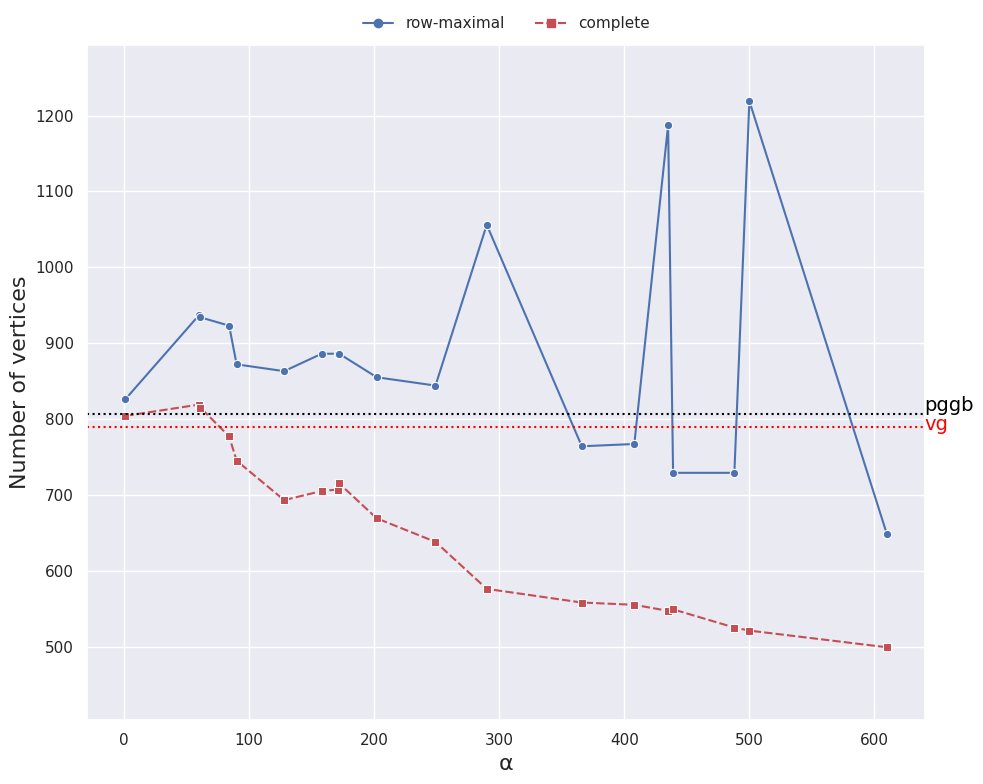

In [ ]:
MARKERS=["o","s"] # o: circle , s: square
COLORS=["b","r"] # b: blue , r: red
DECOMPOSITIONS = ["row-maximal", "complete"]

g_nodes = sns.lineplot(
                    data=df_graphs.query("objective_function=='blocks'"),
                    x="alpha", 
                    y=feature, 
                    hue="decomposition", 
                    style="decomposition", 
                    markers=MARKERS, 
                    palette=COLORS,
                    style_order=DECOMPOSITIONS,
                    hue_order=DECOMPOSITIONS,
                    )

g_nodes.set_xlabel(f"{chr(945)}", fontsize=FONTSIZE_X)
g_nodes.set_ylabel("Number of vertices", fontsize=FONTSIZE_Y)
g_nodes.set_ylim([ymin,ymax])

# add pggb
g_nodes.axhline(y=info_pggb[feature], linestyle=":",color = "black", label="pggb")
g_nodes.text(x=xpos_pggb,y=info_pggb[feature]*1.005,s="pggb", color="black", fontdict=dict(fontsize=FONTSIZE_TOOLS))

# add vg
g_nodes.axhline(y=info_vg[feature], linestyle=":",color = "red", label="vg",)
g_nodes.text(x=xpos_vg,y=info_vg[feature]*0.995,s="vg", color="red", fontdict=dict(fontsize=FONTSIZE_TOOLS))

sns.move_legend(
    g_nodes, "lower center",
    bbox_to_anchor=(.5, 1), ncol=5, title="", frameon=False,
)

g_nodes.figure.tight_layout()
g_nodes.get_figure().savefig(PATH_SAVE.joinpath(f"{NAME}-n_vertices-blocks.png"),dpi=300)

In [ ]:
df_graphs.query("objective_function=='blocks'").groupby("decomposition").size()

decomposition
complete       19
row-maximal    19
dtype: int64

In [ ]:
df_graphs.query("objective_function=='blocks'")

,objective_function,penalization,min_coverage,min_len,alpha,alpha_consistent,decomposition,path,n_nodes,n_edges,len_graph,potential_seeds_len10,potential_seeds_len15,potential_seeds_len20,nodes_depth_gt_03
57,blocks,0,0.0,0,500,False,complete,/data/analysis-paper/paper-experiment-decompos...,521,858,466093,461591,459165,456773,0.168906
58,blocks,0,0.0,0,435,False,complete,/data/analysis-paper/paper-experiment-decompos...,547,873,382817,378252,375787,373341,0.191956
59,blocks,0,0.0,0,610,False,complete,/data/analysis-paper/paper-experiment-decompos...,499,780,451266,446933,444556,442198,0.172345
60,blocks,0,0.0,0,172,False,complete,/data/analysis-paper/paper-experiment-decompos...,715,1134,177276,171687,168702,165749,0.271329
61,blocks,0,0.0,0,249,False,complete,/data/analysis-paper/paper-experiment-decompos...,638,1039,283868,278697,275906,273125,0.202194
62,blocks,0,0.0,0,90,False,complete,/data/analysis-paper/paper-experiment-decompos...,745,1104,85387,80214,77517,74882,0.370470
63,blocks,0,0.0,0,202,False,complete,/data/analysis-paper/paper-experiment-decompos...,669,1073,254990,249639,246762,243903,0.240658
64,blocks,0,0.0,0,366,False,complete,/data/analysis-paper/paper-experiment-decompos...,558,901,326235,321650,319173,316705,0.193548
65,blocks,0,0.0,0,60,False,complete,/data/analysis-paper/paper-experiment-decompos...,819,1237,62981,57582,54892,52306,0.395604
66,blocks,0,0.0,0,84,False,complete,/data/analysis-paper/paper-experiment-decompos...,777,1191,73427,68051,65294,62614,0.365508
